In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

# Uncomment the follwing line to enabled devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import copy
import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.1',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Additional devlib modules required for this experiment
    "modules" : ['hwmon'],
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
             "sched_switch",
             "sched_load_avg_cpu",
             "cpu_frequency",
             "cpu_capacity"
         ],
         "buffsize" : 10240
    },

}

In [4]:
# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

10:46:43  INFO    :         Target - Using base path: /home/derkling/Code/lisa
10:46:43  INFO    :         Target - Loading custom (inline) target configuration
10:46:43  INFO    :         Target - Loading custom (inline) test configuration
10:46:43  INFO    :         Target - Devlib modules to load: ['bl', 'cpufreq', 'hwmon']
10:46:43  INFO    :         Target - Connecting linux target:
10:46:43  INFO    :         Target -   username : root
10:46:43  INFO    :         Target -       host : 192.168.0.1
10:46:43  INFO    :         Target -   password : 
10:47:20  INFO    :         Target - Initializing target workdir:
10:47:20  INFO    :         Target -    /root/devlib-target
10:47:30  INFO    :         Target - Topology:
10:47:30  INFO    :         Target -    [[0, 3, 4, 5], [1, 2]]
10:47:32  INFO    :       Platform - Loading default EM:
10:47:32  INFO    :       Platform -    /home/derkling/Code/lisa/libs/utils/platforms/juno.json
10:47:33  INFO    :         FTrace - Enabled tracepo

In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

10:47:33  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


# Support functions

These are a set of functions to run a workload with different CPUFreq configurations

In [6]:
def set_performance():
    target.cpufreq.set_all_governors('performance')

def set_powersave():
    target.cpufreq.set_all_governors('powersave')

def set_interactive():
    target.cpufreq.set_all_governors('interactive')

def set_sched():
    target.cpufreq.set_all_governors('sched')

def set_ondemand():
    target.cpufreq.set_all_governors('ondemand')
    
    # Configure the MAX sampling rate supporte by the LITTLE cores
    littles_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.littles[0])
    target.cpufreq.set_governor_tunables(
        target.bl.littles[0], 'ondemand',
        **{'sampling_rate' : littles_tunables['sampling_rate_min']}
    )
    
    # Configure the MAX sampling rate supporte by the big cores
    bigs_tunables = target.cpufreq.get_governor_tunables(
                            target.bl.bigs[0])
    target.cpufreq.set_governor_tunables(
        target.bl.bigs[0], 'ondemand',
        **{'sampling_rate' : bigs_tunables['sampling_rate_min']}
    )
    

In [7]:
# CPUFreq configurations to test
confs = {
    'performance' : {
        'label' : 'prf',
        'set' :  set_performance,
    },
    'powersave' : {
        'label' : 'pws',
        'set' :  set_powersave,
    },
#     'interactive' : {
#         'label' : 'int',
#         'set' :  set_interactive,
#     },
    'sched' : {
        'label' : 'sch',
        'set' :  set_sched,
    },
    'ondemand' : {
        'label' : 'odm',
        'set' :  set_ondemand,
    }
}

# The set of results forlder for each comparition test
results = {}

In [8]:
def experiment(governor, rtapp, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()

    # Start FTrace and Energy monitoring
    te.ftrace.start()
    te.emeter.reset()
    
    # Run the workload
    rtapp.run(out_dir=exp_dir)
    
    # Stop FTrace and sample Energy consumption
    nrg = te.emeter.report(exp_dir).channels
    te.ftrace.stop()
    
    logging.info('Energy: %s', nrg)
    
    # Dump platform description
    te.platform_dump(exp_dir)
    
    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(exp_dir,
               my_tests_conf['ftrace']['events'],
               te.platform)
    
    # return all the experiment data
    return {
        'dir'      : exp_dir,
        'energy'   : copy.deepcopy(nrg),
        'trace'    : trace_file,
        'tr'       : tr,
        'ftrace'   : tr.ftrace
    }

    
def compare(tid, rtapp):    
    logging.info('Test case: %s', tid)
    
    res_dir = os.path.join(te.res_dir, tid)
    logging.info('  results folder: %s', res_dir)
    
    # Run the workload in all the configured governors
    results[tid] = {}
    for governor in confs:
        test_dir = os.path.join(res_dir, governor)
        results[tid][governor] = experiment(governor, rtapp, test_dir)
        
def plot(tid):
    global results
    
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        templates,
                        column=column,
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
        
    for governor in confs:
        pa = PerfAnalysis(results[tid][governor]['dir'])
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
        
def report_nrg(tid):
    global results
    
    print "{:15s} | {:>9s} {:>9s} {:>9s}"\
        .format('Governor', 'A53', 'A57', 'Total')
    print "{:-<16s}+{:-<30s}".format('', '')
    for governor in confs:
        plot_title = "{}".format(governor.upper())
        nrg = results[tid][governor]['energy']
        nrg_little = float(nrg['little'])
        nrg_big = float(nrg['big'])
        nrg_sum = nrg_little + nrg_big
        print "{:15s} | {:9.3f} {:9.3f} {:9.3f}"\
            .format(governor, nrg_little, nrg_big, nrg_sum)

# Test: light/heavy/light

In [9]:
# Define a label for this test case
test_case = 'light-heavy-light'

cpus = str(target.bl.bigs_online[0])
light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=cpus)
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100,
                  cpus=cpus)
light2 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                 cpus=cpus)

lhl_task = light1 + heavy1 + light2

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhl_task.get()
    },
    run_dir=target.working_directory
);

10:47:34  INFO    :          WlGen - Setup new workload smoke
10:47:34  INFO    :          RTApp - Workload duration defined by longest task
10:47:34  INFO    :          RTApp - Default policy: SCHED_OTHER
10:47:34  INFO    :          RTApp - ------------------------
10:47:34  INFO    :          RTApp - task [task1], sched: using default policy
10:47:34  INFO    :          RTApp -  | calibration CPU: 1
10:47:34  INFO    :          RTApp -  | loops count: 1
10:47:34  INFO    :          RTApp -  | CPUs affinity: 1
10:47:34  INFO    :          RTApp - + phase_000001: duration 1.000000 [s] (100 loops)
10:47:34  INFO    :          RTApp - |  period    10000 [us], duty_cycle  10 %
10:47:34  INFO    :          RTApp - |  run_time   1000 [us], sleep_time   9000 [us]
10:47:34  INFO    :          RTApp - + phase_000002: duration 0.100000 [s] (1 loops)
10:47:34  INFO    :          RTApp - |  period   100000 [us], duty_cycle  90 %
10:47:34  INFO    :          RTApp - |  run_time  90000 [us], sleep

In [10]:
# Run this workload in all the configurations
compare(test_case, rtapp)

10:47:34  INFO    : Test case: light-heavy-light
10:47:34  INFO    :   results folder: /home/derkling/Code/lisa/results/20160226_104733/light-heavy-light
10:47:34  INFO    : ------------------------
10:47:34  INFO    : Run workload using performance governor
10:47:39  INFO    :          WlGen - Workload execution START:
10:47:39  INFO    :          WlGen -    /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
10:47:43  INFO    : Energy: {'a53': {'total': 0.7573389999997744, 'last': 10886.575534, 'delta': 0.7573389999997744}, 'a57': {'total': 4.061310999999478, 'last': 14412.11884, 'delta': 4.061310999999478}}
10:47:46  INFO    : Collected events spans a 5.957 [s] time interval
10:47:46  INFO    : Set plots time range to (0.000000, 5.957349)[s]
10:47:46  INFO    : ------------------------
10:47:46  INFO    : Run workload using sched governor
10:47:51  INFO    :          WlGen - Workload execution START:
10:47:51  INFO    :          WlGen -    /root/devlib-target/bin/rt-app

In [11]:
# Plot all data collected from experiments
def plot(tid):
    global results
    
    # Plot CPU LoadAvg and Capacity (for CPU0)
    for governor in confs:
        plot_title = "{} Governor".format(governor.upper())
        trappy.LinePlot(results[tid][governor]['ftrace'],
                        signals=[
                            "sched_load_avg_cpu:util_avg",
                            "cpu_capacity:capacity"],
                        pivot="cpu",
                        filters={"cpu": [1]},
                        marker = '+',
                        drawstyle='steps-post',
                        title=plot_title,
                        ylim=(0, 1100)).view()
    
    # Plot Custer Frequencies and report averate frequencies
    for governor in confs:
        plot_title = "Cluster frequencies, {}".format(governor.upper())
        trace = results[tid][governor]['tr']
        logging.info("%s:", plot_title)
        trace.analysis.frequency.plotClusterFrequencies(title=plot_title)
    
    # Plot RTApp performance index
    for governor in confs:
        plot_title = "RTApp performances, {}".format(governor.upper())
        pa = PerfAnalysis(results[tid][governor]['dir'])
        logging.info("%s:", plot_title)
        for task in pa.tasks():
            pa.plotPerf(task, "Performance using [{}] governor"\
                                .format(governor))
            

/home/derkling/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/derkling/.local/lib/python2.7/site-packages/matplotlib/legend.py:633: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#using-proxy-artist
  "#using-proxy-artist".format(orig_handle)
10:48:35  INFO    : Cluster frequencies, PERFORMANCE:
10:48:35  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:48:35  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:48:35  INFO    : LITTLE cluster average frequency: 0.850 GHz
10:48:35  INFO    : big    cluster average frequency: 1.100 GHz
10:48:35  INFO    : Cluster frequencies, SCHED:
10:48:35  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:48:35  WARNING : Events [sched_overuti

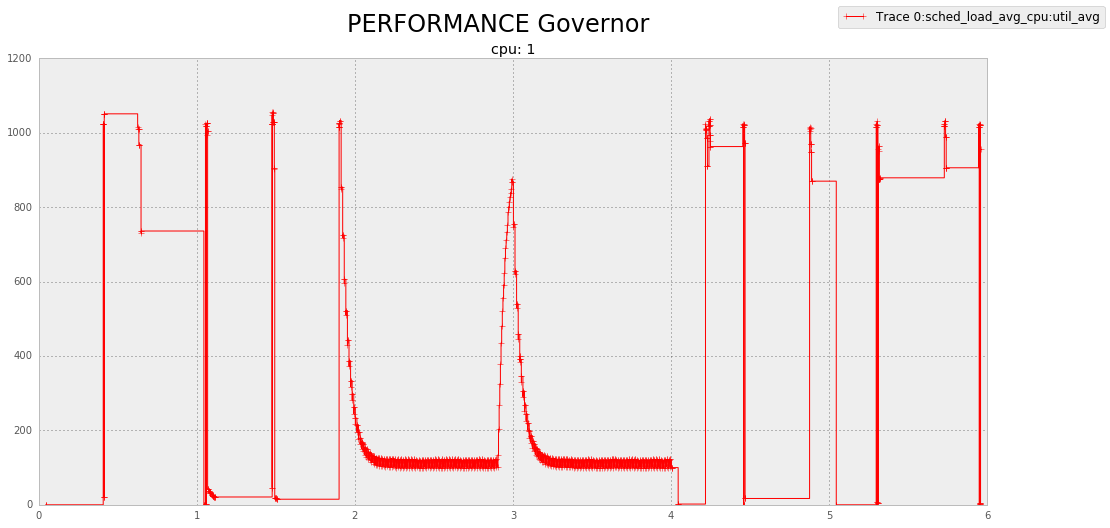

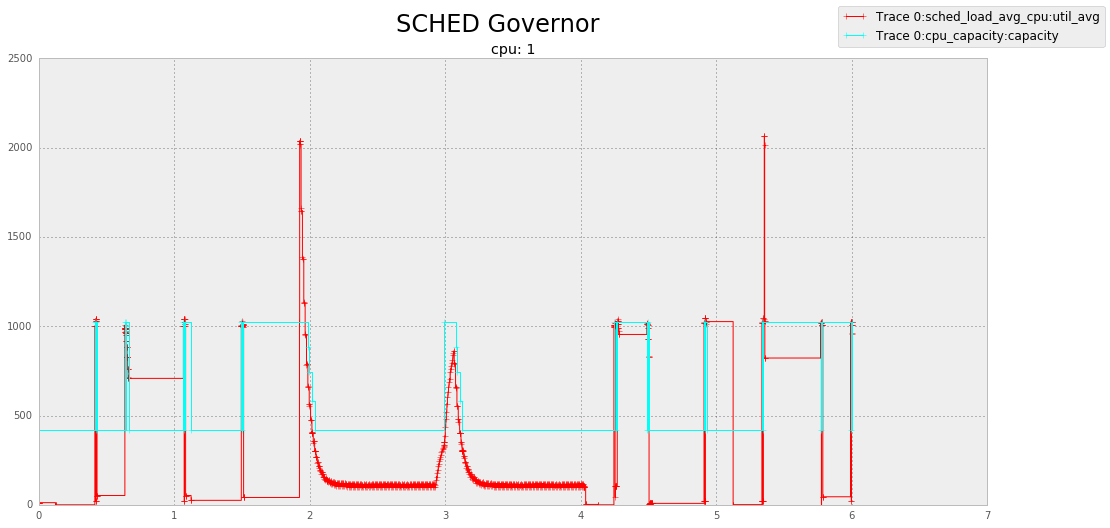

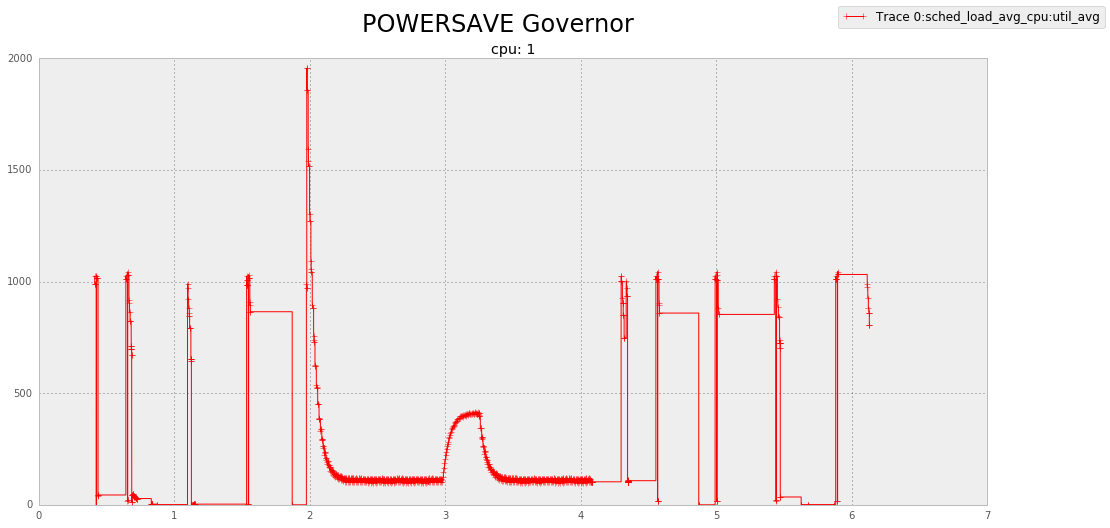

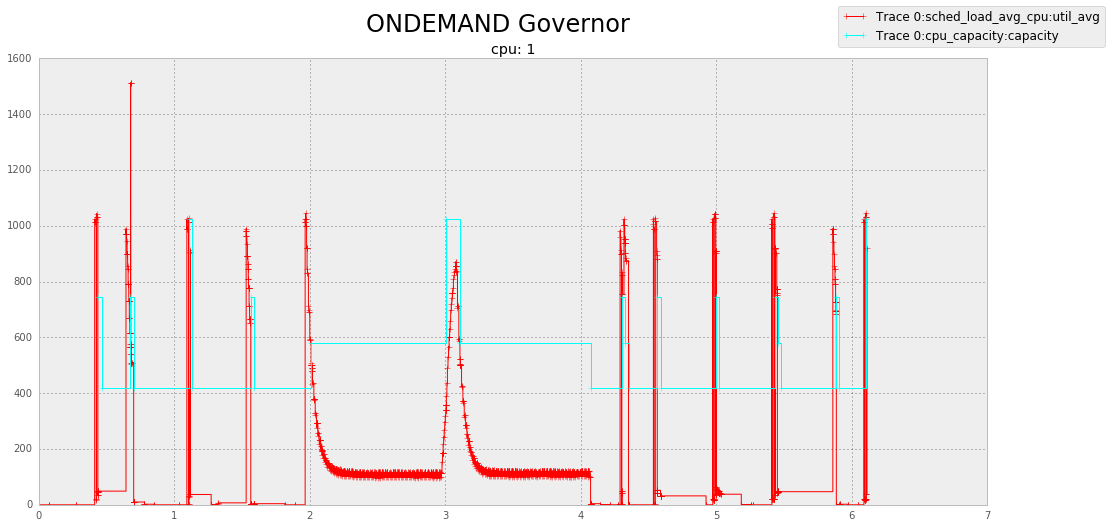

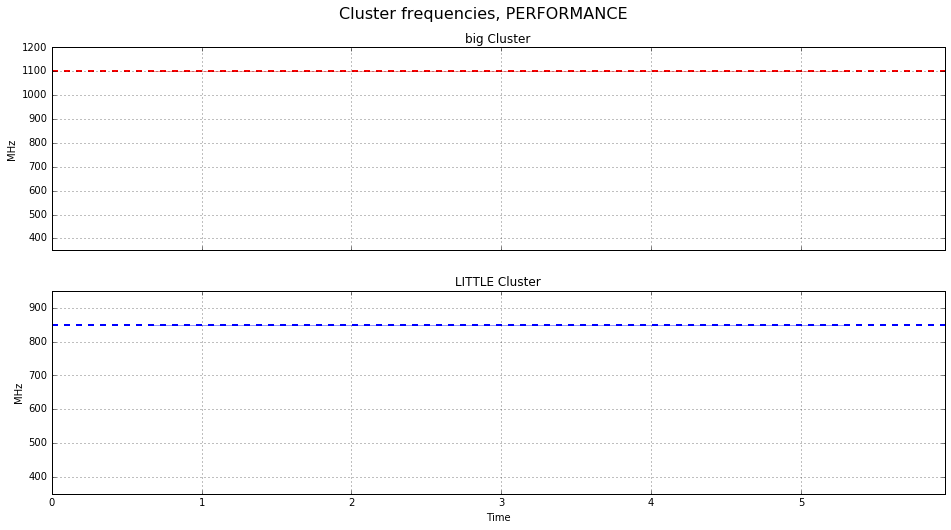

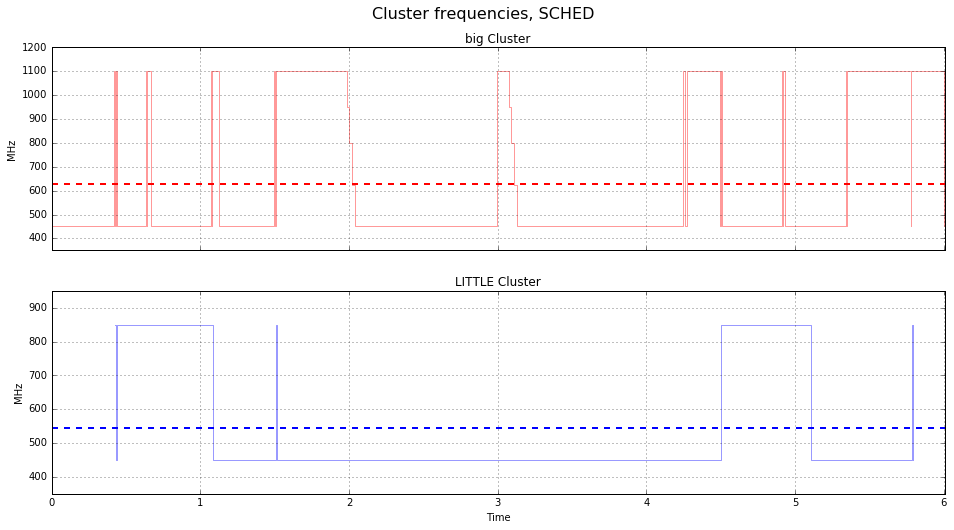

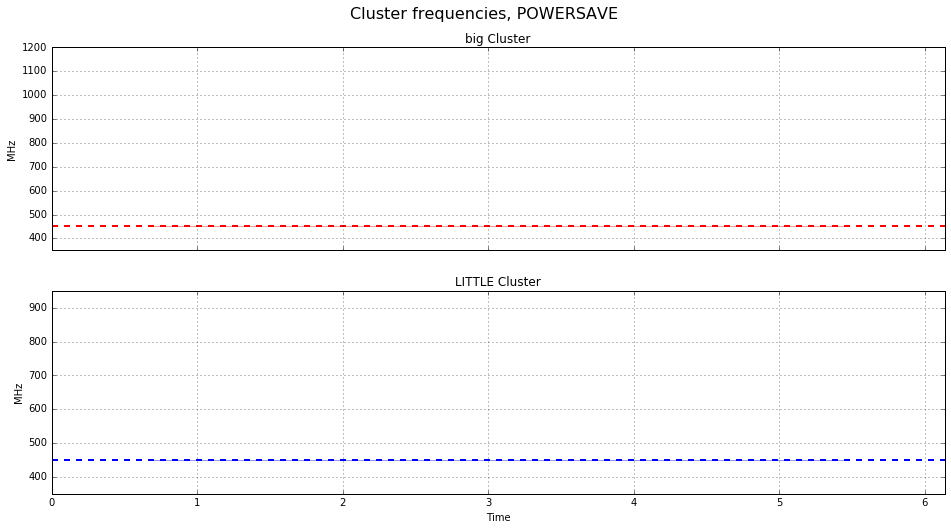

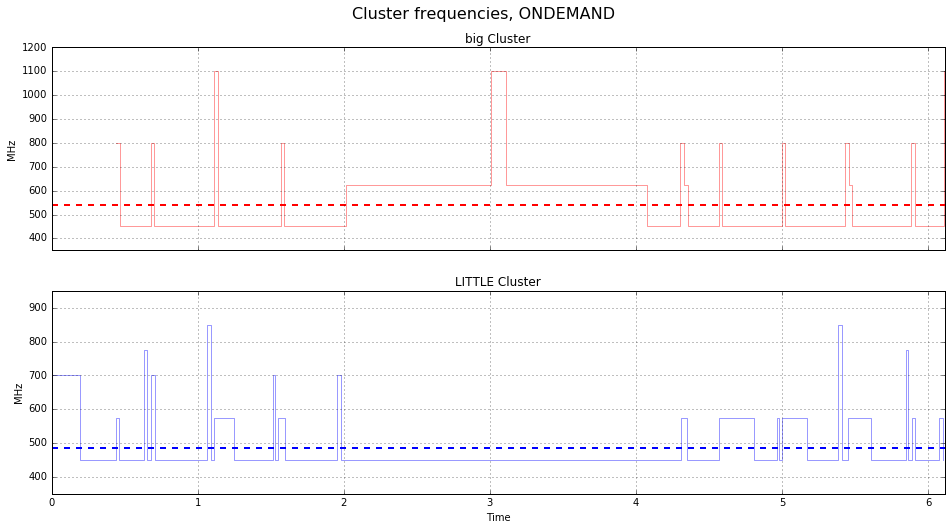

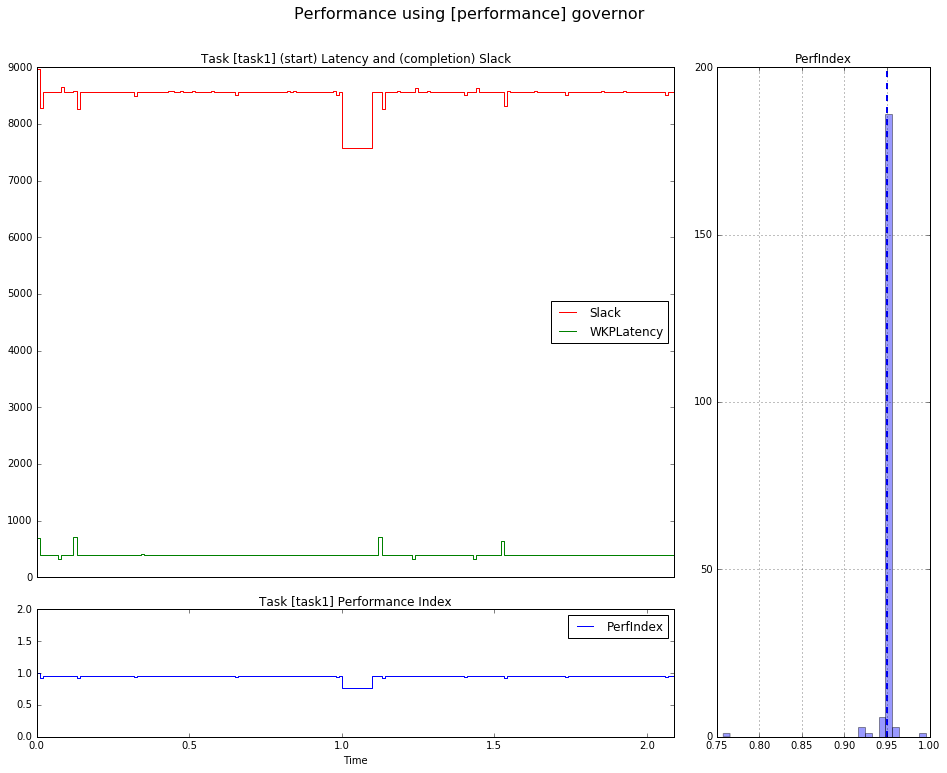

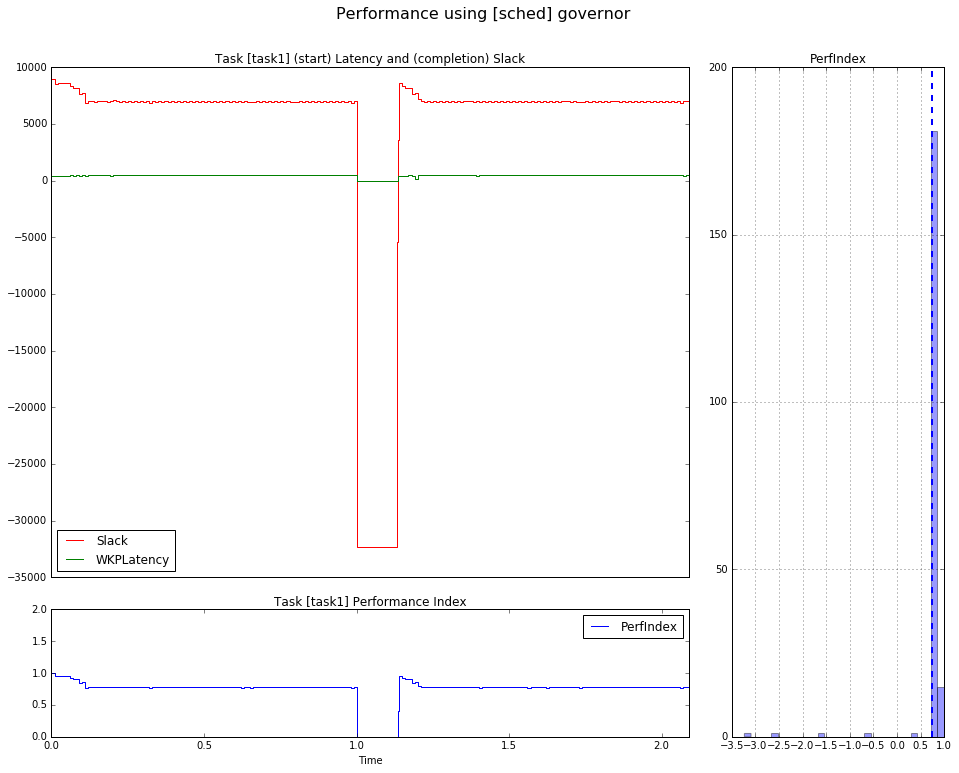

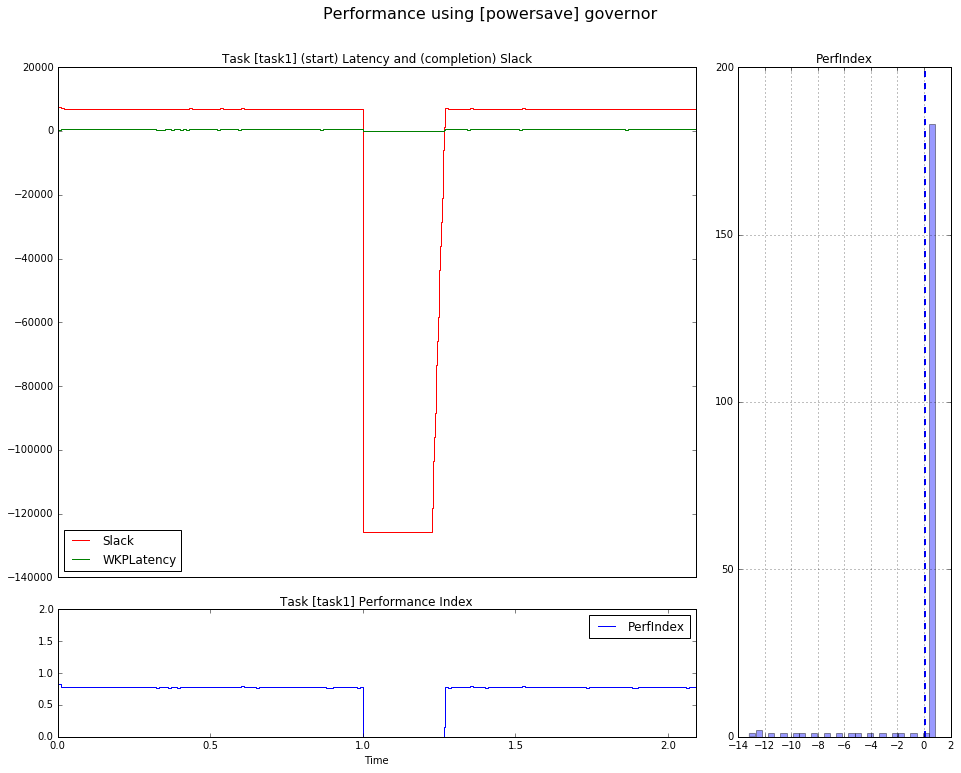

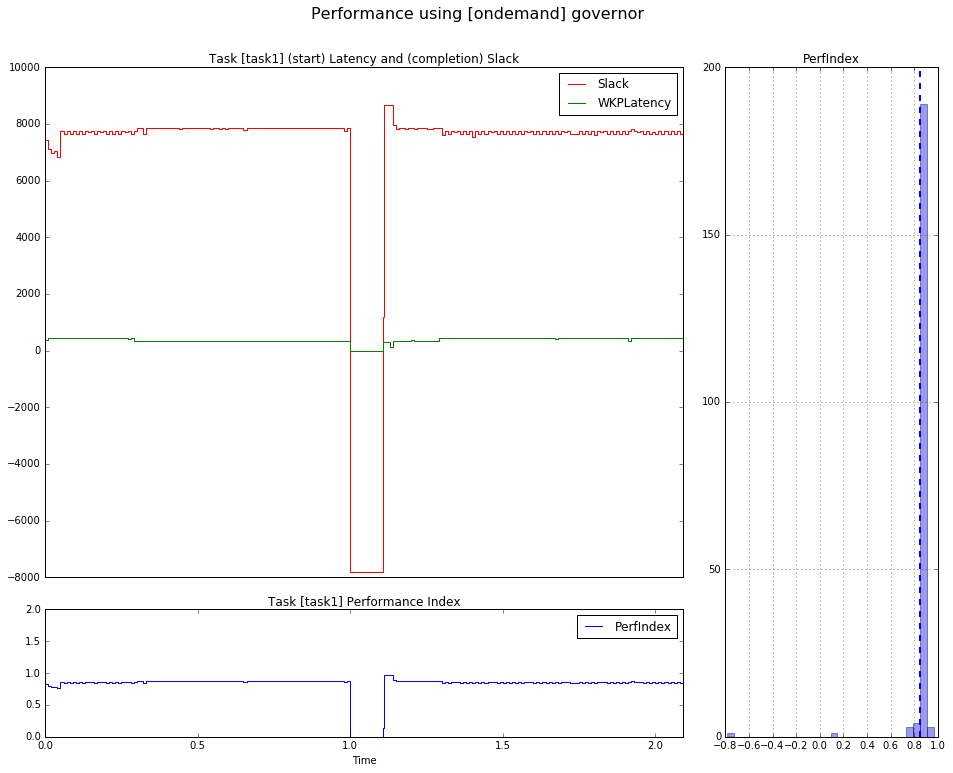

In [12]:
plot(test_case)

In [13]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.757     4.061     4.819
sched           |     0.552     2.910     3.462
powersave       |     0.537     2.483     3.020
ondemand        |     0.493     2.992     3.485


# Test: light/heavy/medium

In [14]:
# Define a label for this test case
test_case = 'light-heavy-medium'

light1 = Periodic(duty_cycle_pct=10, duration_s=1.0, period_ms= 10,
                  cpus=str(target.bl.bigs_online[0]))
heavy1 = Periodic(duty_cycle_pct=90, duration_s=0.1, period_ms=100)
mdium1 = Periodic(duty_cycle_pct=50, duration_s=1.0, period_ms= 10)

lhm_task = light1 + heavy1 + mdium1

rtapp = RTA(target, 'smoke', calibration=te.calibration())
rtapp.conf(
    kind='profile',
    params={
        'task1' : lhm_task.get()
    },
    run_dir=target.working_directory
);



10:48:40  INFO    :          WlGen - Setup new workload smoke
10:48:40  INFO    :          RTApp - Workload duration defined by longest task
10:48:40  INFO    :          RTApp - Default policy: SCHED_OTHER
10:48:40  INFO    :          RTApp - ------------------------
10:48:40  INFO    :          RTApp - task [task1], sched: using default policy
10:48:40  INFO    :          RTApp -  | calibration CPU: 1
10:48:40  INFO    :          RTApp -  | loops count: 1
10:48:40  INFO    :          RTApp -  | CPUs affinity: 1
10:48:40  INFO    :          RTApp - + phase_000001: duration 1.000000 [s] (100 loops)
10:48:40  INFO    :          RTApp - |  period    10000 [us], duty_cycle  10 %
10:48:40  INFO    :          RTApp - |  run_time   1000 [us], sleep_time   9000 [us]
10:48:40  INFO    :          RTApp - + phase_000002: duration 0.100000 [s] (1 loops)
10:48:40  INFO    :          RTApp - |  period   100000 [us], duty_cycle  90 %
10:48:40  INFO    :          RTApp - |  run_time  90000 [us], sleep

In [15]:
# Run this workload in all the configurations
compare(test_case, rtapp)

10:48:40  INFO    : Test case: light-heavy-medium
10:48:40  INFO    :   results folder: /home/derkling/Code/lisa/results/20160226_104733/light-heavy-medium
10:48:40  INFO    : ------------------------
10:48:40  INFO    : Run workload using performance governor
10:48:45  INFO    :          WlGen - Workload execution START:
10:48:45  INFO    :          WlGen -    /root/devlib-target/bin/rt-app /root/devlib-target/smoke_00.json
10:48:49  INFO    : Energy: {'a53': {'total': 0.9306930000002467, 'last': 10908.156155, 'delta': 0.9306930000002467}, 'a57': {'total': 7.310747999999876, 'last': 14450.407846, 'delta': 7.310747999999876}}
10:48:52  INFO    : Collected events spans a 5.960 [s] time interval
10:48:52  INFO    : Set plots time range to (0.000000, 5.960423)[s]
10:48:52  INFO    : ------------------------
10:48:52  INFO    : Run workload using sched governor
10:48:57  INFO    :          WlGen - Workload execution START:
10:48:57  INFO    :          WlGen -    /root/devlib-target/bin/rt-

10:49:40  INFO    : Cluster frequencies, PERFORMANCE:
10:49:40  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:40  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:40  INFO    : LITTLE cluster average frequency: 0.850 GHz
10:49:40  INFO    : big    cluster average frequency: 1.100 GHz
10:49:40  INFO    : Cluster frequencies, SCHED:
10:49:40  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:40  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:41  INFO    : LITTLE cluster average frequency: 0.537 GHz
10:49:41  INFO    : big    cluster average frequency: 0.615 GHz
10:49:41  INFO    : Cluster frequencies, POWERSAVE:
10:49:41  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:41  WARNING : Events [sched_overutilized] not found, plot DISABLED!
10:49:41  INFO    : LITTLE cluster average frequency: 0.450 GHz
10:49:41  INFO    : big    cluster average frequency: 0.450 GHz
10:49:41  INFO    

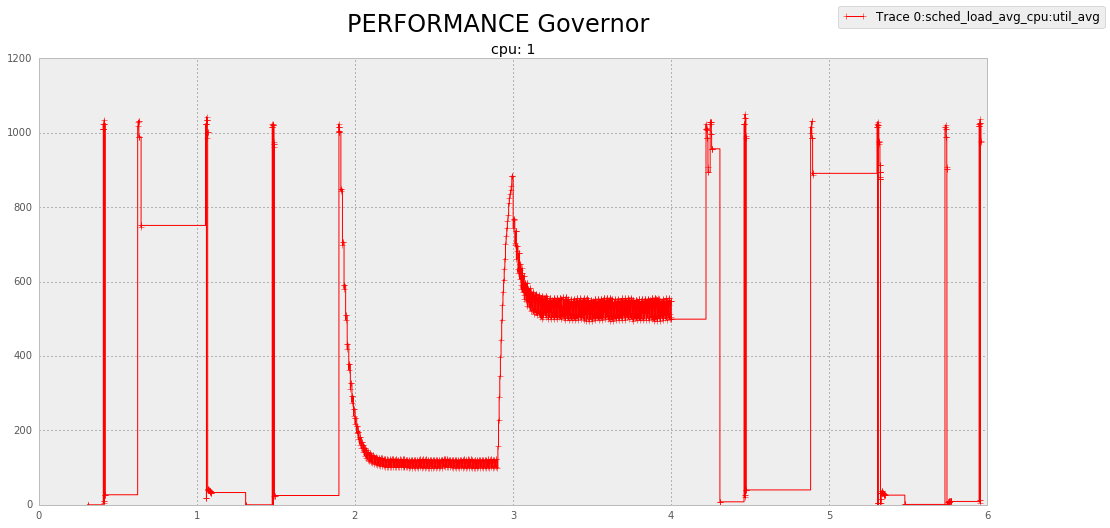

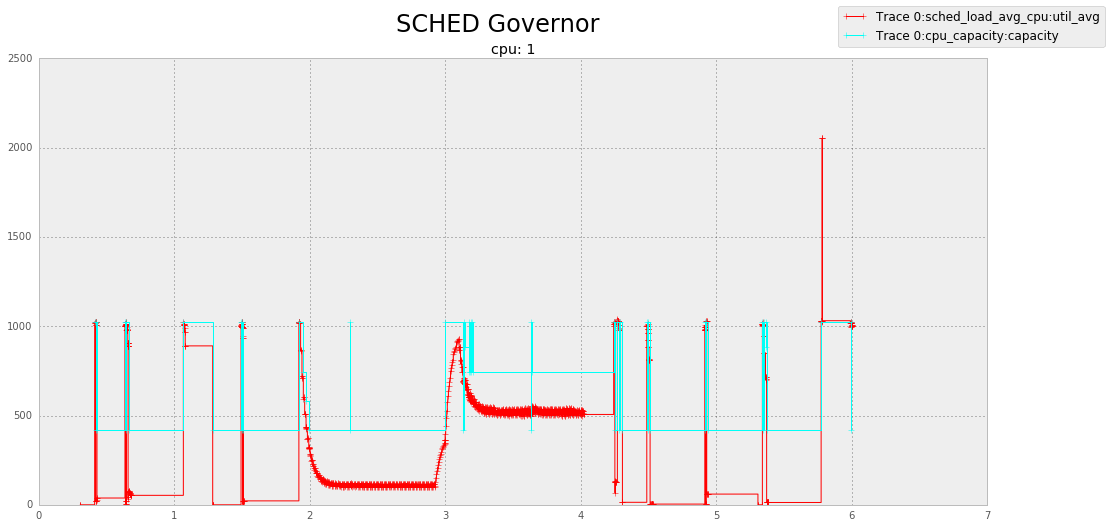

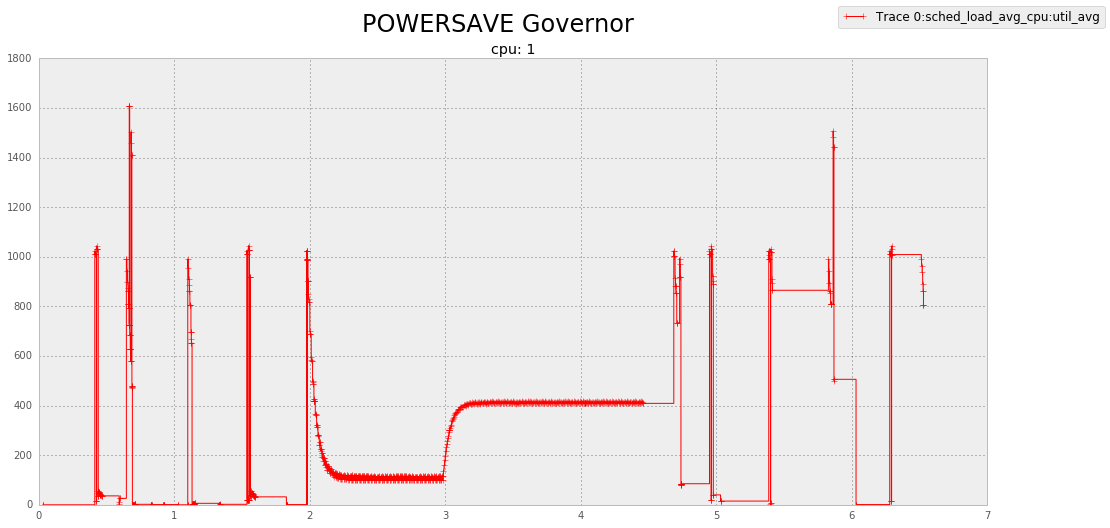

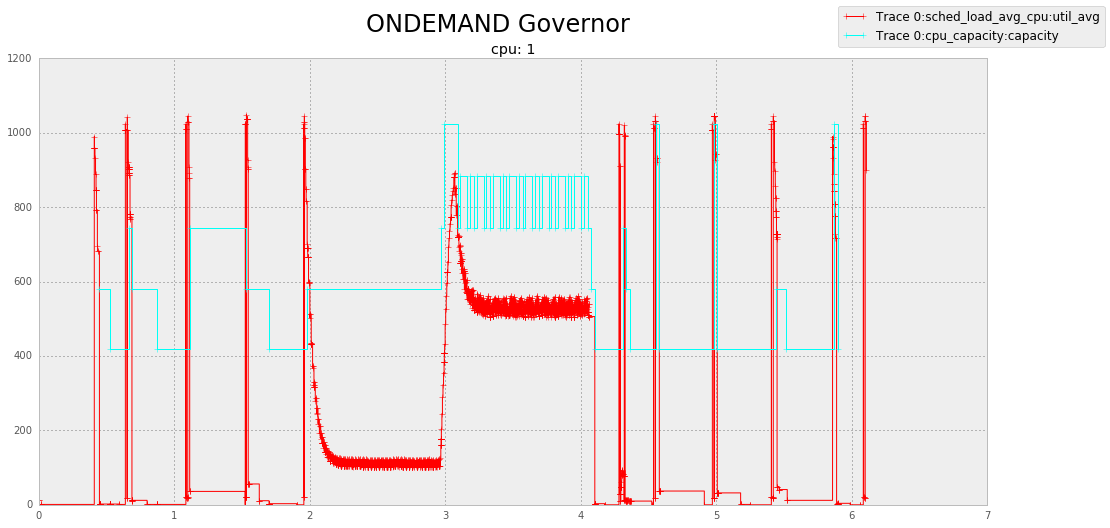

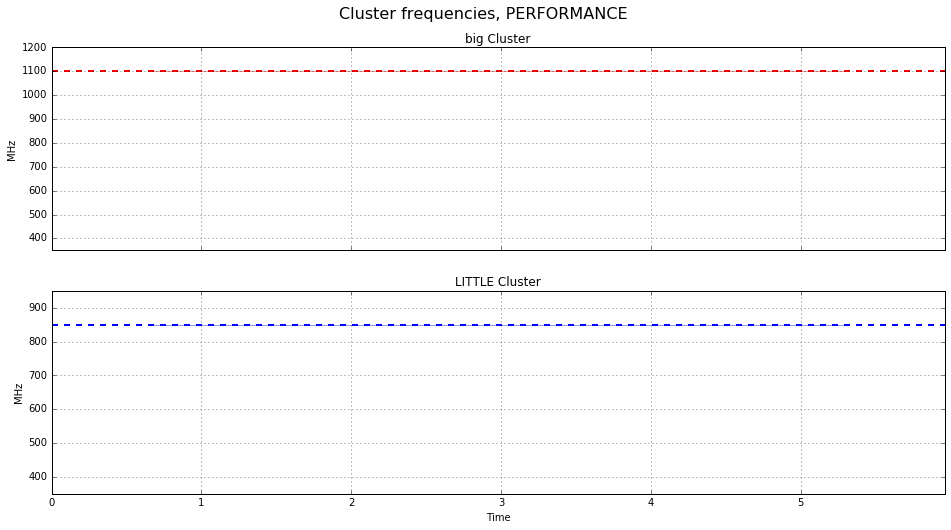

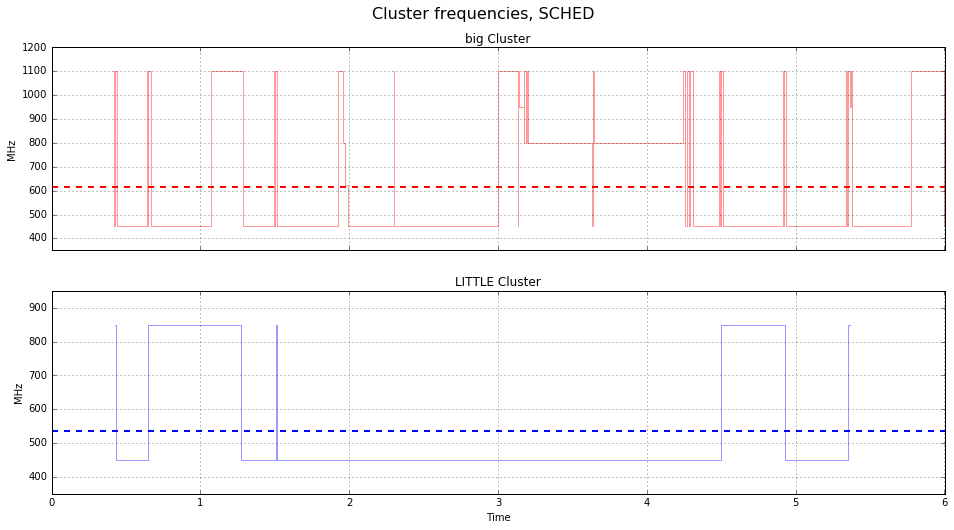

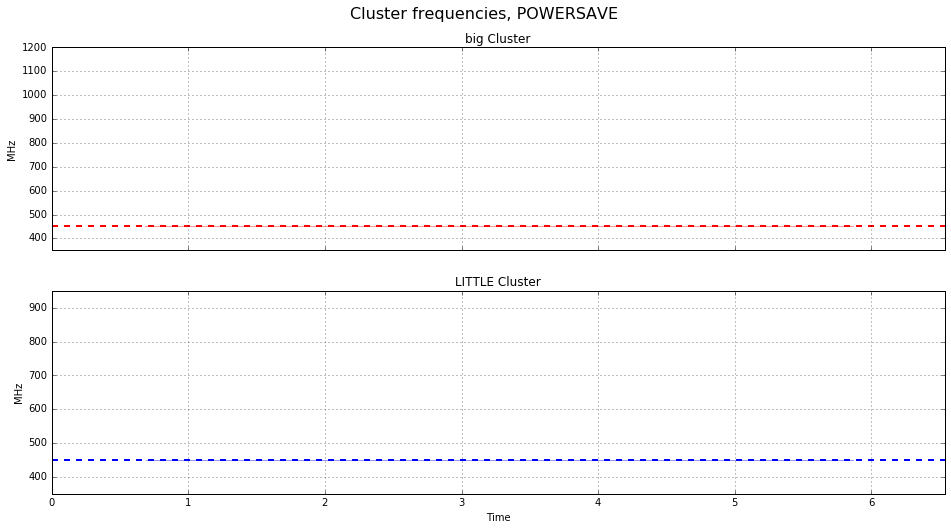

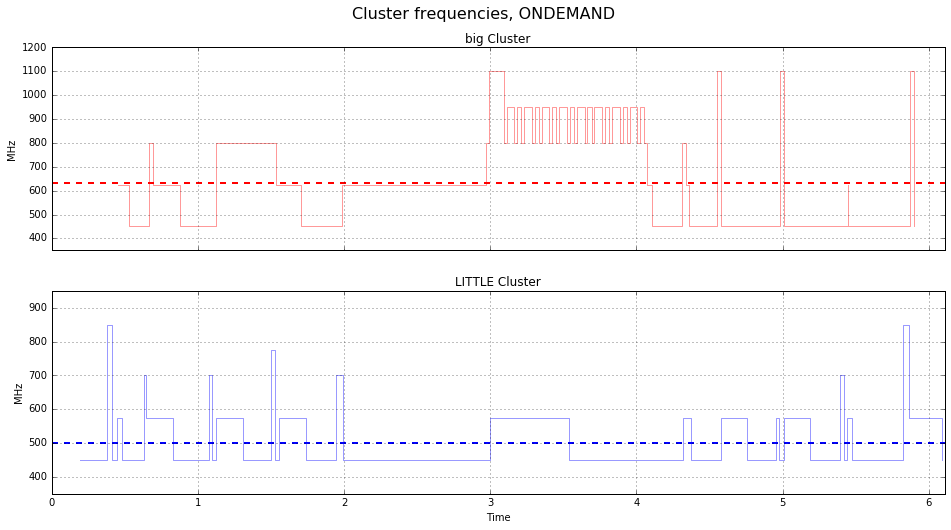

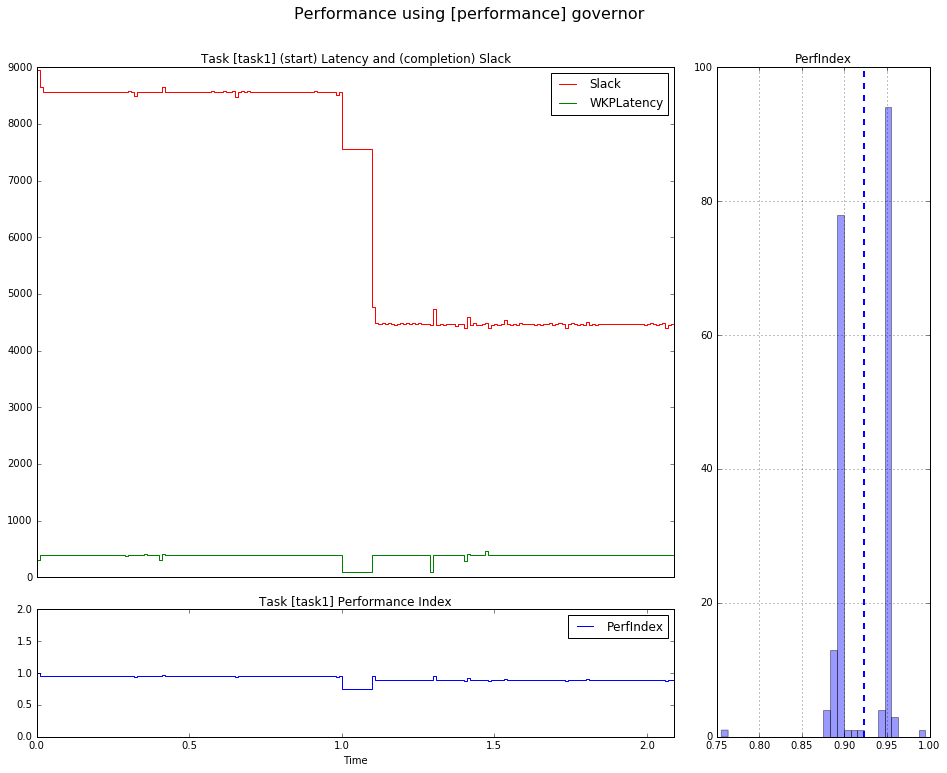

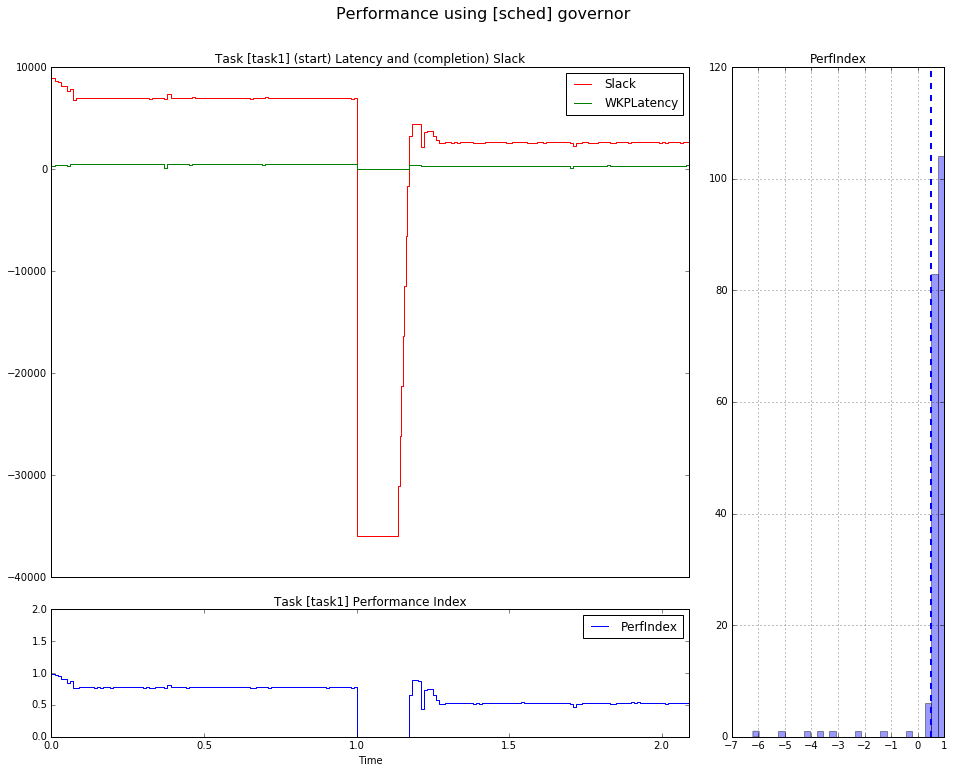

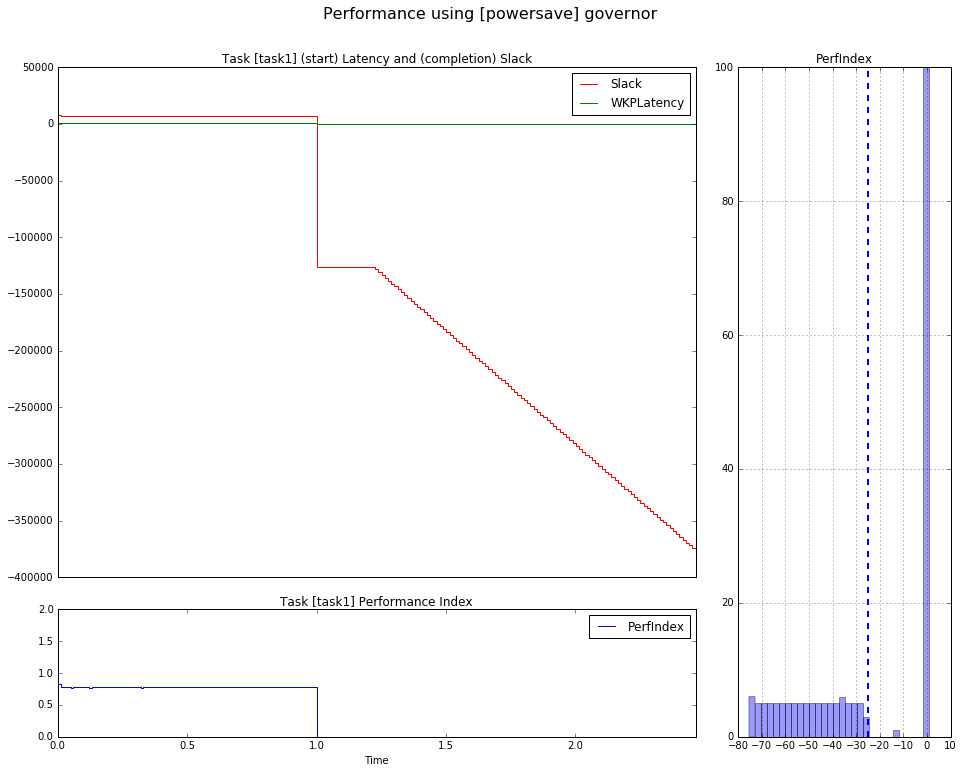

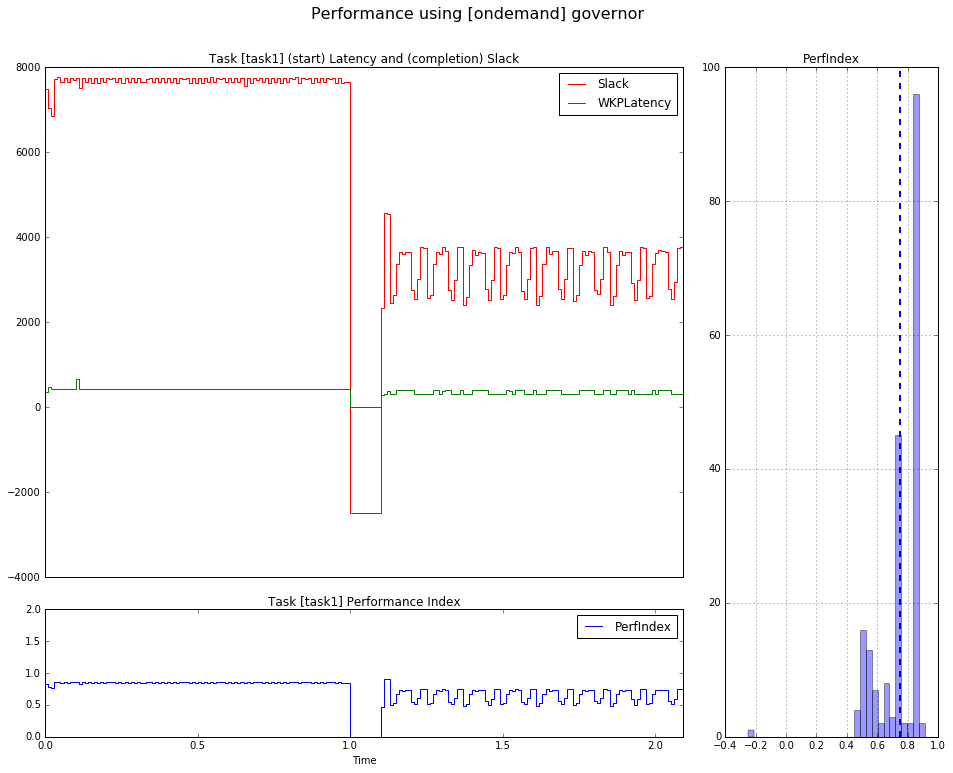

In [16]:
plot(test_case)

In [17]:
report_nrg(test_case)

Governor        |       A53       A57     Total
----------------+------------------------------
performance     |     0.931     7.311     8.241
sched           |     0.544     5.823     6.368
powersave       |     0.534     4.575     5.108
ondemand        |     0.527     5.990     6.516
